# Fully Connected Neural Network

In this example, we show how one can train a neural network on a specific task (here, Iris Classification) and convert it to its FHE counterpart such that it runs over encrypted data.

In [1]:
import time

import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm import tqdm

from concrete.ml.sklearn import NeuralNetClassifier

### Define all required variables to train the model

In [2]:
# Get iris data-set

X, y = load_iris(return_X_y=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scikit-Learn and Concrete ML neural networks only handle float32 input values
X_train, X_test = X_train.astype("float32"), X_test.astype("float32")

## Model training and evaluation

In [3]:
params = {
    "module__n_layers": 3,
    "module__activation_function": nn.ReLU,
    "max_epochs": 1000,
    "verbose": 0,
}
model = NeuralNetClassifier(**params)

In [4]:
model, sklearn_model = model.fit_benchmark(X=X_train, y=y_train)

In [5]:
# Evaluate the sklearn model, which needs to specifically be of type float32
y_pred_sklearn = sklearn_model.predict(X_test)

sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn) * 100
print(f"The test accuracy of the trained scikit-learn model is {sklearn_accuracy:.2f}%")

The test accuracy of the trained scikit-learn model is 100.00%


In [6]:
# Evaluate the Concrete ML model in the clear
y_pred_simulated = model.predict(X_test)

simulated_accuracy = accuracy_score(y_test, y_pred_simulated) * 100
print(f"The test accuracy of the trained Concrete ML simulated model is {simulated_accuracy:.2f}%")

The test accuracy of the trained Concrete ML simulated model is 97.37%


## FHE Inference

In [7]:
# Compile the model to have before
fhe_circuit = model.compile(X_train)

### Generate the key

In [8]:
print("Generating a key for a " f"{fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for a 8-bit circuit


In [9]:
time_begin = time.time()
fhe_circuit.client.keygen(force=True)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 1.45 seconds


### Predict in FHE

In [10]:
fhe_predictions = []
time_begin = time.time()
for x in tqdm(X_test):
    y_ = model.predict(np.array([x]), fhe="execute")[0]
    fhe_predictions.append(y_)

print(f"Execution time: {(time.time() - time_begin) / len(X_test):.2f} seconds per sample")

  0%|          | 0/38 [00:00<?, ?it/s]

  3%|▎         | 1/38 [00:01<01:10,  1.91s/it]

  5%|▌         | 2/38 [00:02<00:45,  1.27s/it]

  8%|▊         | 3/38 [00:03<00:37,  1.08s/it]

 11%|█         | 4/38 [00:04<00:37,  1.09s/it]

 13%|█▎        | 5/38 [00:05<00:32,  1.01it/s]

 16%|█▌        | 6/38 [00:07<00:45,  1.43s/it]

 18%|█▊        | 7/38 [00:09<00:42,  1.37s/it]

 21%|██        | 8/38 [00:09<00:34,  1.16s/it]

 24%|██▎       | 9/38 [00:10<00:29,  1.02s/it]

 26%|██▋       | 10/38 [00:11<00:25,  1.09it/s]

 29%|██▉       | 11/38 [00:11<00:23,  1.17it/s]

 32%|███▏      | 12/38 [00:12<00:21,  1.22it/s]

 34%|███▍      | 13/38 [00:13<00:20,  1.25it/s]

 37%|███▋      | 14/38 [00:14<00:20,  1.19it/s]

 39%|███▉      | 15/38 [00:15<00:18,  1.23it/s]

 42%|████▏     | 16/38 [00:15<00:17,  1.25it/s]

 45%|████▍     | 17/38 [00:16<00:16,  1.27it/s]

 47%|████▋     | 18/38 [00:17<00:15,  1.28it/s]

 50%|█████     | 19/38 [00:18<00:17,  1.10it/s]

 53%|█████▎    | 20/38 [00:19<00:15,  1.14it/s]

 55%|█████▌    | 21/38 [00:20<00:14,  1.19it/s]

 58%|█████▊    | 22/38 [00:20<00:13,  1.22it/s]

 61%|██████    | 23/38 [00:21<00:12,  1.25it/s]

 63%|██████▎   | 24/38 [00:22<00:12,  1.15it/s]

 66%|██████▌   | 25/38 [00:23<00:12,  1.07it/s]

 68%|██████▊   | 26/38 [00:24<00:10,  1.09it/s]

 71%|███████   | 27/38 [00:25<00:09,  1.13it/s]

 74%|███████▎  | 28/38 [00:26<00:08,  1.18it/s]

 76%|███████▋  | 29/38 [00:26<00:07,  1.21it/s]

 79%|███████▉  | 30/38 [00:27<00:06,  1.24it/s]

 82%|████████▏ | 31/38 [00:28<00:05,  1.26it/s]

 84%|████████▍ | 32/38 [00:29<00:04,  1.28it/s]

 87%|████████▋ | 33/38 [00:30<00:03,  1.28it/s]

 89%|████████▉ | 34/38 [00:30<00:03,  1.29it/s]

 92%|█████████▏| 35/38 [00:31<00:02,  1.30it/s]

 95%|█████████▍| 36/38 [00:32<00:01,  1.30it/s]

 97%|█████████▋| 37/38 [00:33<00:00,  1.21it/s]

100%|██████████| 38/38 [00:34<00:00,  1.25it/s]

100%|██████████| 38/38 [00:34<00:00,  1.12it/s]

Execution time: 0.90 seconds per sample


### Compare the accuracy scores

In [11]:
fhe_accuracy = accuracy_score(y_test, fhe_predictions) * 100

print(f"Test accuracy using the sklearn model: {sklearn_accuracy:.2f}%")
print(f"Test accuracy using the Concrete ML simulated model: {simulated_accuracy:.2f}%")
print(f"Test accuracy using the Concrete ML FHE model: {fhe_accuracy:.2f}%")

Test accuracy using the sklearn model: 100.00%
Test accuracy using the Concrete ML simulated model: 97.37%
Test accuracy using the Concrete ML FHE model: 97.37%


### Plot the predicted boundaries

Although we executed the predictions on encrypted data when testing our model's performance, here the boundaries are predictions made over clear data points using simulated FHE, making this notebook faster to run. Predictions in FHE are expected to equivalent to these, as we showed above.

In [12]:
# Create a 2D grid in order to visualize predictions and contours for both models
pca = PCA(n_components=2, random_state=np.random.randint(0, 2**15))
X_test_2d = pca.fit_transform(X_test)

b_min = np.min(X_test_2d, axis=0)
b_max = np.max(X_test_2d, axis=0)

grid_dims = tuple(
    np.linspace(b_min[i], b_max[i], 512, dtype=X_test.dtype) for i in range(X_test_2d.shape[1])
)
ndgrid_tuple = np.meshgrid(*grid_dims)
grid_2d = np.vstack([g.ravel() for g in ndgrid_tuple]).transpose()

grid_test = pca.inverse_transform(grid_2d)

# Evaluate the predicted classes using the sklearn model
grid_pred_sklearn = sklearn_model.predict_proba(grid_test)
pred_sklearn_classes = np.argmax(grid_pred_sklearn, axis=1)

# Evaluate the predicted classes using the Concrete ML simulated model
# Pylint is disabled because it does not seem to be able to understand that `model` is a
# NeuralClassifier instance and support the predict_proba method. This may be solved by removing
# Skorch and Sklearn inheritance
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/3373
grid_pred_fhe = model.predict_proba(grid_test)  # pylint: disable=no-member
pred_fhe_classes = np.argmax(grid_pred_fhe, axis=1)

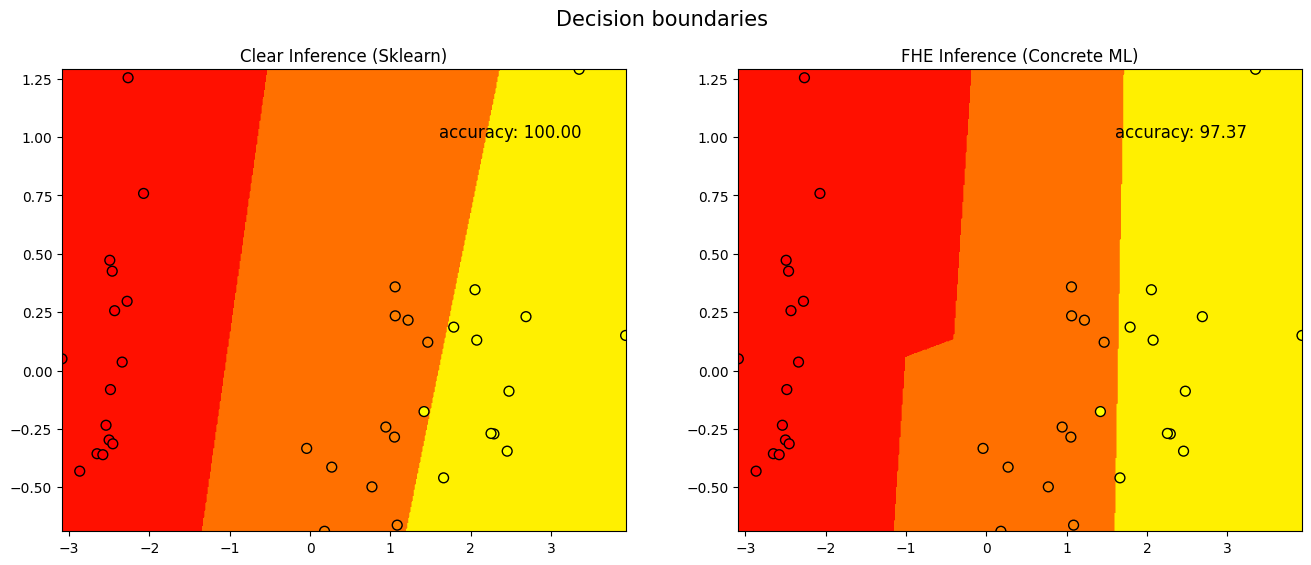

In [13]:
%matplotlib inline

cmap = "autumn"

classes_to_plot = [
    (pred_sklearn_classes, "Clear Inference (Sklearn)", sklearn_accuracy),
    (pred_fhe_classes, "FHE Inference (Concrete ML)", simulated_accuracy),
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (classes, title, accuracy) in enumerate(classes_to_plot):
    ax = axes[i]

    # Plot contours based on the predicted classes
    ax.contourf(
        ndgrid_tuple[0],
        ndgrid_tuple[1],
        classes.reshape(ndgrid_tuple[0].shape),
        cmap=cmap,
        label="ookko",
    )

    # Set the title and legend text
    ax.set_title(title)
    ax.text(1.6, 1, f"accuracy: {accuracy:.2f}", size=12)

    # Plot the test data as a scatter with marker borders
    ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, s=50, edgecolors="k", cmap=cmap)

fig.suptitle("Decision boundaries", size=15)
plt.show()

## Conclusion

In this notebook, we presented a NeuralNetworkClassifier model built with:

- [Skorch](https://github.com/skorch-dev/skorch) to have a scikit-learn like API wrapped around [Torch](https://github.com/pytorch/pytorch). 
- [Brevitas](https://github.com/Xilinx/brevitas) which provides low-bit Quantization Aware Training functionality to Torch.

The final accuracy of the model in clear can then be expected in FHE (which is what we observe here).
